# IA024 - Modelagem de linguagem (Bengio et al., 2003)
Data: 2024 S2 \
Autores: Roberto Lotufo, Jayr Pereira, Diedre Carmo

(Bengio et al., 2003): Modelo capaz de prever a próxima palavra a partir de um contexto.

Dados: textos de Machado de Assis

Modelagem:

Entrada: quantidade pré-definida de palavras representa um contexto. Palavras são representadas através de inteiros resultantes de tokenização.

Rede Neural: palavras são transformadas em Embeddings, de onde deriva-se uma predição da próxima palavra com camadas lineares (Rede Neural MLP).

Saída: próxima palavra dado o contexto.

Avaliação: Perplexidade: uma medida da incerteza de um modelo de probabilidade em prever uma amostra.

Geração de Texto: Com este modelo, é possível gerar um texto através de janela deslizante de contexto.




## Imports

In [ ]:
import os
import re
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.nn import Embedding
from collections import Counter

## Dados


### Aquisição do dataset, preparação e análise

In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 3.25 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
# >>> Análise varia dependendo do formato que os dados são fornecidos <<<

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    data_text = data_file.read()

# Número total de caracteres no dataset
len(data_text)

18845445

In [ ]:
# Dados já foram separados em linhas
# Checar tamanho das linhas em caracteres, por curiosidade
lines = []
line_lens = []

with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        lines.append(line)
        line_lens.append(len(line))


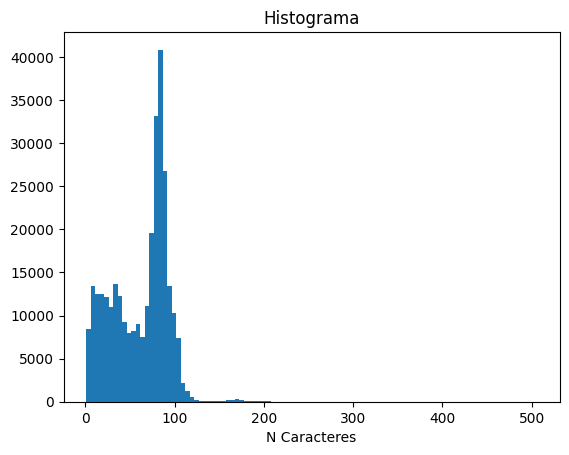

In [ ]:
plt.title("Histograma")
plt.hist(line_lens, bins=100)
plt.xlabel("N Caracteres")
plt.show()

In [ ]:
# Limpar linhas, removendo \n, espaços antes e depois
with open(DATA_PATH, "r") as data_file:
    cleaned_lines = [line.strip().lower() for line in data_file]

len(cleaned_lines)

306409

In [ ]:
# Quantidade total de caracteres após limpeza
acum_chars = 0
for cleaned_line in cleaned_lines:
    acum_chars += len(cleaned_line)

acum_chars

# Possível fazer de forma mais "Pythônica"?

18539036

In [ ]:
# É possível voltar a um texto monolítico juntando as linhas. Nota-se que estamos adicionando espaços, mas não há mais \n
full_data = ' '.join(cleaned_lines)
len(full_data)

18845444

In [ ]:
# Separar em treino e teste
limit = int(0.8*len(cleaned_lines))
train_cleaned_lines = cleaned_lines[:limit]
val_cleaned_lines = cleaned_lines[limit:]

# Não utilize o split val para nada a partir daqui, somente validar

In [ ]:
# Como descobrir o número de palavras únicas?
# Separar palavras com regex
import re

#### re.findall

## Modelagem baseada em (Bengio et al. 2003)


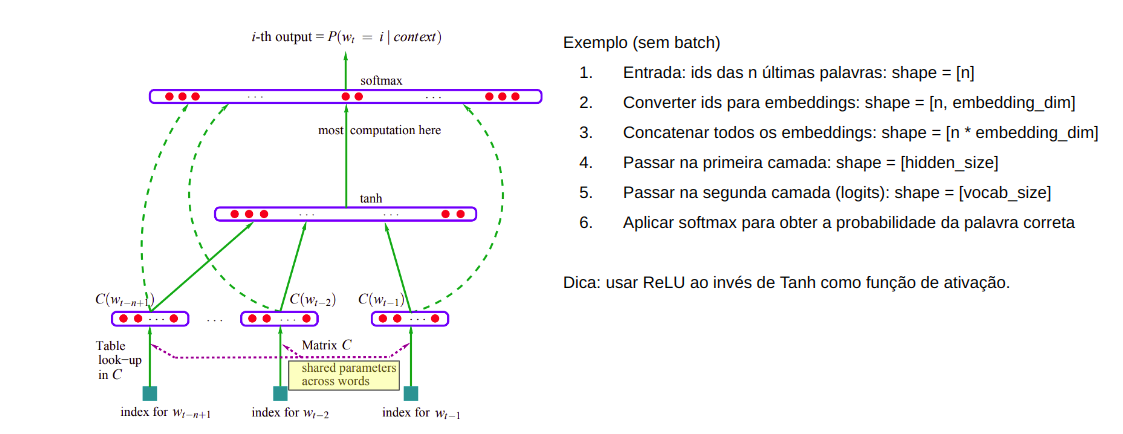

# Enunciado do Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural similar a do Bengio 2003 para prever a próxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Linguagem".

Portanto, você deve implementar o modelo de linguagem inspirado no artigo do Bengio, para prever a próxima palavra usando rede com embeddings e duas camadas.
Sugestão de alguns parâmetros:
* context_size = 5
* max_vocab_size = 2000
* embedding_dim = 64
* usar pontuação no vocabulário
* descartar qualquer contexto ou target que não esteja no vocabulário
* É esperado conseguir uma perplexidade da ordem de **150**.
* Procurem fazer asserts para garantir que partes do seu programa estão testadas

Este enunciado não é fixo, podem mudar qualquer um dos parâmetros acima, mas procurem conseguir a perplexidade esperada ou menor.

Gerem alguns frases usando um contexto inicial e depois deslocando o contexto e prevendo a próxima palavra gerando frases compridas para ver se está gerando texto plausível.

Algumas dicas:
- Inclua caracteres de pontuação (ex: `.` e `,`) no vocabulário.
- Deixe tudo como caixa baixa (lower-case).
- A escolha do tamanho do vocabulario é importante: ser for muito grande, fica difícil para o modelo aprender boas representações. Se for muito pequeno, o modelo apenas conseguirá gerar textos simples.
- Remova qualquer exemplo de treino/validação/teste que tenha pelo menos um token desconhecido (ou na entrada ou na saída).
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

Procure por `TODO` para entender onde você precisa inserir o seu código.

# Vocabulário

In [ ]:
def count_words(texts):
    word_counts = Counter()
    for text in texts:
        word_counts.update(re.findall(r'\w+|[.,!?:;]', text.lower()))
    return word_counts

word_counts = count_words(cleaned_lines)
vocab_size = 2000
most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
most_frequent_words[:5]

[',', '.', 'a', 'que', 'de']

# Tokenização

In [ ]:
def encode_sentence(sentence, vocab):
    # Usa regex para separar palavras (sequências alfa numéricas)
    return [vocab.get(word, 0) for word in re.findall(r'\w+|[.,!?:;]', sentence.strip().lower())]

# Exemplo de tokenização
random_sentence = random.choice(cleaned_lines)
encoded_sentence = encode_sentence(random_sentence, vocab)
print(f"{random_sentence}\n{encoded_sentence}")

chapéus altos de homens públicos, e nunca lhe pareceu tão torpe. de noite, encontrando a
[0, 0, 5, 263, 0, 1, 6, 147, 34, 566, 67, 0, 2, 5, 120, 1, 0, 3]


In [ ]:
random_sentence = 'oposição'
encoded_sentence = encode_sentence(random_sentence, vocab)
print(f"{random_sentence}\n{encoded_sentence}")

oposição
[0]


In [ ]:
last_word = list(vocab.keys())[-1]
last_word

'lados'

## Classe do dataset

A Classe Dataset é um dos aspectos mais trabalhosos do desenvolvimento de modelos com Deep Learning. Crie uma classe Dataset do PyTorch para este problema. Lembre-se de documentar e testar utilizando-se de asserts. Explique sua lógica de forma concisa com comentários.  

In [ ]:
from torch.utils.data import Dataset

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra
"""TODO: Preparar o dataset"""
class TextDataset(Dataset):
    """
    Dataset para a tarefa de modelagem de linguagem com pares (contexto, target).

    Args:
        lines (list): Lista de linhas de texto.
        vocab (dict): Dicionário de vocabulário, mapeando palavras para índices.
        context_size (int): Tamanho do contexto (número de palavras).

    Attributes:
        pairs (list): Lista de pares (contexto, target) onde contexto é uma lista de índices e target é um índice.
    """

    def __init__(self, lines, vocab, context_size):
        self.pairs = self.create_context_target_pairs(lines, vocab, context_size)

    def create_context_target_pairs(self, lines, vocab, context_size):
        context_target_pairs = []
        for line in lines:
            tokens = encode_sentence(line, vocab)

            # Filtra linhas que contenham tokens desconhecidos
            if 0 in tokens:
                continue

            if len(tokens) >= context_size + 1:
                for i in range(len(tokens) - context_size):
                    context = tokens[i:i + context_size]
                    target = tokens[i + context_size]
                    context_target_pairs.append((context, target))
        return context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [ ]:
"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""
from sklearn.model_selection import train_test_split
# Dividir as linhas limpas em treino e validação (80/20)
train_cleaned_lines, val_cleaned_lines = train_test_split(cleaned_lines, test_size=0.2, random_state=18)

In [ ]:
"""TODO: implemente a classe do dataset"""

train_data = TextDataset(train_cleaned_lines, vocab, context_size)
val_data = TextDataset(val_cleaned_lines, vocab, context_size)

# Exemplo de acesso a um item do dataset
sample_context, sample_target = train_data[0]
print(f"Contexto: {sample_context}, Target: {sample_target}")
sample_context, sample_target = train_data[1]
print(f"Contexto: {sample_context}, Target: {sample_target}")

Contexto: tensor([185, 331,  19, 565,   1]), Target: 14
Contexto: tensor([331,  19, 565,   1,  14]), Target: 726


In [ ]:
# Função para validar se nenhum par contém o token 0 (token desconhecido)
def validate_no_unknown_tokens(dataset):
    for i in range(len(dataset)):
        context, target = dataset[i]
        assert 0 not in context, f"Contexto contém token desconhecido (0) no índice {i}: {context}"
        assert target != 0, f"Target contém token desconhecido (0) no índice {i}: {target}"

# Validando o dataset de treino e validação
validate_no_unknown_tokens(train_data)
validate_no_unknown_tokens(val_data)

print("Todos os pares de contexto e target estão livres de tokens desconhecidos (0).")

Todos os pares de contexto e target estão livres de tokens desconhecidos (0).


### Inicialização de DataLoaders
Os DataLoaders do PyTorch cuidam da criação do batch de forma eficiente e com possibildade de paralelismo. Sempre visualize exemplos do DataLoader para verificar que o batch está sendo criado da forma esperada. Grande parte dos erros ocorrem na definição do Dataset e do Dataloader.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
sample = next(iter(train_loader))

In [ ]:
context_batch, target_batch = sample

print(f"Dimensões do contexto no lote: {context_batch.shape}")
print(f"Dimensões do alvo no lote: {target_batch.shape}")

Dimensões do contexto no lote: torch.Size([32, 5])
Dimensões do alvo no lote: torch.Size([32])


## Model
Crie uma classe de Modelo herdando de torch.nn.Module. Um nn.Module deve definir o que acontece no "forward", ou seja, o que é feito com o dado (geralmente o batch) fornecido para a rede.

Procure ler sobre a documentação do nn.Module e entender porque é necessário que a classe do modelo precisa herdar de nn.Module.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LanguageModel(nn.Module):
    """
    Modelo de linguagem inspirado no artigo de Bengio (2003).
    Utiliza embeddings e uma rede neural com duas camadas totalmente conectadas.

    Args:
        vocab_size (int): Tamanho do vocabulário.
        embedding_dim (int): Dimensão dos embeddings.
        hidden_dim (int): Dimensão da camada oculta.
        context_size (int): Tamanho do contexto.
    """
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(LanguageModel, self).__init__()

        # Camada de embeddings
        self.embeddings = nn.Embedding(vocab_size+1, embedding_dim)

        # Primeira camada totalmente conectada
        self.fc1 = nn.Linear(embedding_dim * context_size, hidden_dim)

        # Segunda camada totalmente conectada (saída)
        self.fc2 = nn.Linear(hidden_dim, vocab_size+1)

    def forward(self, x):
        """
        Propagação para frente do modelo.

        Args:
            x (Tensor): Tensor de entrada com os índices das palavras (contexto).

        Returns:
            Tensor: Saídas da rede neural (logits para cada palavra do vocabulário).
        """
        # Passar pelas embeddings
        embedded = self.embeddings(x)  # Shape: (batch_size, context_size, embedding_dim)

        # Achatar as embeddings para passar pela primeira camada totalmente conectada
        embedded = embedded.view(embedded.size(0), -1)  # Shape: (batch_size, context_size * embedding_dim)

        # Passar pela primeira camada totalmente conectada
        hidden = F.relu(self.fc1(embedded))

        # Passar pela segunda camada totalmente conectada (saída)
        logits = self.fc2(hidden)

        # Aplicar softmax para obter probabilidades
        # output = F.log_softmax(logits, dim=1) -> Alterado após ver os dos colegas e relembrar que a CrossEntropyLoss faz o softmax
        output = logits

        return output

In [ ]:
  total_params = 0
  for name, param in model.named_parameters():
      if param.requires_grad:
          print(f"{name}: {param.size()} - {param.numel()} parâmetros")
          total_params += param.numel()

  print(f"Número total de parâmetros: {total_params}")

embeddings.weight: torch.Size([2001, 64]) - 128064 parâmetros
fc1.weight: torch.Size([128, 320]) - 40960 parâmetros
fc1.bias: torch.Size([128]) - 128 parâmetros
fc2.weight: torch.Size([2001, 128]) - 256128 parâmetros
fc2.bias: torch.Size([2001]) - 2001 parâmetros
Número total de parâmetros: 427281


In [ ]:
print(model)

LanguageModel(
  (embeddings): Embedding(2001, 64)
  (fc1): Linear(in_features=320, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2001, bias=True)
)


### Teste do modelo
É essencial testar o forward do modelo antes de tentar treinar, muitos erros podem ser pegos neste teste rápido. Use uma amostra do DataLoader para testar se as saídas são o esperado.

In [ ]:
embedding_dim = 64  # Dimensão dos embeddings
hidden_dim = 128 # Dimensão da camada oculta
model = LanguageModel(vocab_size, embedding_dim, context_size)

In [ ]:
# sample = next(iter(train_loader))
input = sample[0]
target = sample[1]

In [ ]:
output = model(input)

In [ ]:
output.argmax(dim=1)

tensor([1643,  908,  212,  147, 1546,  672,  291, 1856, 1544, 1021, 1608,  307,
        1272, 1167,  287,  644, 1131,  291,  908, 1568, 1680, 1412,  238, 1460,
        1609, 1568,  362,  252, 1182, 1926, 1868,  569])

In [ ]:
target

tensor([1473,  666,    2,    2,    1,    5,    2,   93,    1,   62,   20,  192,
           3,    2,    4,    7,    7,    1,    2,  507,   28,    1,   23,  302,
           9, 1307,    4,  774,   11,   98,  482,  464])

## Training
Finalmente, implemente o loop de treino, onde os dados são fornecidos ao modelo, e os otimizadores otimizam os pesos do modelo em uma tentativa de minimizar a função de perda.

Ele envolve o uso de instâncias de otimizadores e funções de perda. Procure organizar o loop de treino em múltiplas funções em vez de um código monolítico, para facilitar a re-utilização de código no futuro.

Procure informar o resultado da loss tanto em treino quanto em validação. Opcional: plote um gráfico da loss em cada época de treino e validação.

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Perplexidade inicial (dataset treino)

In [ ]:
#""" TODO: calcule a perplexidade final no dataset de validação """
model = LanguageModel(vocab_size, embedding_dim, context_size)
model.to(device)
criterion = nn.CrossEntropyLoss() #"""TODO CrossEntropy""""
def calculate_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_words = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            # Forward pass
            outputs = model(contexts)

            # Calculate the loss
            loss = criterion(outputs, targets)

            # Accumulate the loss and the number of words
            total_loss += loss.item() * contexts.size(0)
            total_words += targets.size(0)

    # Compute the average loss
    avg_loss = total_loss / total_words

    # Calculate the perplexity
    perplexity = np.exp(avg_loss)

    return perplexity

# Exemplo de uso
train_perplexity = calculate_perplexity(model, train_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {train_perplexity:.2f}")

Perplexidade no conjunto de validação: 2067.08


Epoch 1/10 - Train Loss: 5.5638 - Val Loss: 5.0573 - Train Accuracy: 0.1486 - Val Accuracy: 0.1866
Epoch 2/10 - Train Loss: 4.9686 - Val Loss: 4.8696 - Train Accuracy: 0.1771 - Val Accuracy: 0.1960
Epoch 3/10 - Train Loss: 4.7487 - Val Loss: 4.7345 - Train Accuracy: 0.1895 - Val Accuracy: 0.2081
Epoch 4/10 - Train Loss: 4.5597 - Val Loss: 4.6271 - Train Accuracy: 0.1996 - Val Accuracy: 0.2138
Epoch 5/10 - Train Loss: 4.3871 - Val Loss: 4.5432 - Train Accuracy: 0.2082 - Val Accuracy: 0.2189
Epoch 6/10 - Train Loss: 4.2253 - Val Loss: 4.4736 - Train Accuracy: 0.2157 - Val Accuracy: 0.2219
Epoch 7/10 - Train Loss: 4.0706 - Val Loss: 4.4199 - Train Accuracy: 0.2250 - Val Accuracy: 0.2282
Epoch 8/10 - Train Loss: 3.9250 - Val Loss: 4.3834 - Train Accuracy: 0.2348 - Val Accuracy: 0.2342
Epoch 9/10 - Train Loss: 3.7892 - Val Loss: 4.3531 - Train Accuracy: 0.2461 - Val Accuracy: 0.2392
Epoch 10/10 - Train Loss: 3.6666 - Val Loss: 4.3334 - Train Accuracy: 0.2605 - Val Accuracy: 0.2453


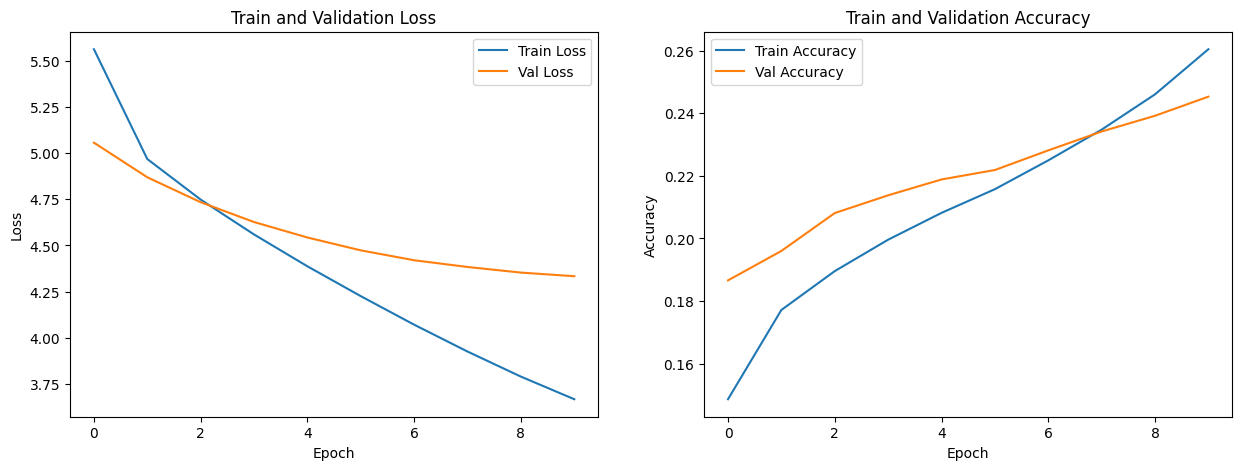

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 10
lr = 1e-4 #"""TODO, experimente!""""
criterion = nn.CrossEntropyLoss() #"""TODO CrossEntropy""""

optimizer = optim.AdamW(model.parameters(), lr=lr) #"""TODO: AdamW ou outro, experimente!""""

model.to(device)

#"""TODO: Implemente o loop de treinamento. Em cada época, calcule e imprima a loss no dataset de validação. Opcional: Plote um gráfico da loss de validação e treino""""
# Função de Treinamento
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for contexts, targets in dataloader:
        contexts, targets = contexts.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(contexts)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * contexts.size(0)

        # Cálculo da acurácia
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Função de Avaliação
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            outputs = model(contexts)

            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * contexts.size(0)

            # Cálculo da acurácia
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Loop de Treinamento e Avaliação
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
              f"Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Treinamento e Avaliação
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)

# Plotar Gráficos de Loss e Acurácia
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Loss
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train and Validation Loss')
    axs[0].legend()

    # Plot de Acurácia
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train and Validation Accuracy')
    axs[1].legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Avaliação
Calcule a perplexidade utilizando todo o dataset de validação. Pesquise o que é a perplexidade e como implementá-la.

In [ ]:
#""" TODO: calcule a perplexidade final no dataset de validação """
# def calculate_perplexity(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0.0
#     total_words = 0

#     with torch.no_grad():
#         for contexts, targets in dataloader:
#             contexts, targets = contexts.to(device), targets.to(device)

#             # Forward pass
#             outputs = model(contexts)

#             # Calculate the loss
#             loss = criterion(outputs, targets)

#             # Accumulate the loss and the number of words
#             total_loss += loss.item() * contexts.size(0)
#             total_words += targets.size(0)

#     # Compute the average loss
#     avg_loss = total_loss / total_words

#     # Calculate the perplexity
#     perplexity = np.exp(avg_loss)

#     return perplexity

# Função já foi definida acima

# Exemplo de uso
val_perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {val_perplexity:.2f}")

Perplexidade no conjunto de validação: 76.20


## Exemplo de uso
Como um modelo de linguagem pode gerar um texto? Pense como uma "janela deslizante", onde o contexto é sempre as palavras anteriores. Produza textos para avaliar o modelo de forma qualitativa.

In [ ]:
def generate_text(model, vocab, start_text, max_length, context_size, device):
    model.eval()

    # Codifique o texto inicial
    context = encode_sentence(start_text, vocab)

    # Garantir que o tamanho do contexto esteja correto
    if len(context) < context_size:
        raise ValueError(f"O contexto inicial deve ter pelo menos {context_size} palavras.")

    generated_indices = context.copy()

    # Começar a geração de texto
    for _ in range(max_length):
        # Obter o contexto atual
        input_context = torch.tensor([context[-context_size:]], dtype=torch.long, device=device)

        # Forward pass
        with torch.no_grad():
            output = model(input_context)

        # Obter a palavra mais provável
        predicted_index = torch.argmax(output, dim=-1).item()

        # Adicionar a palavra ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    # Converter índices para palavras
    idx_to_word = {idx: word for word, idx in vocab.items()}
    generated_words = [idx_to_word.get(idx, 0) for idx in generated_indices]

    return ' '.join(generated_words)

def select_valid_example(cleaned_lines, vocab, context_size):
    valid_examples = []

    for line in cleaned_lines:
        encoded_line = encode_sentence(line, vocab)
        # Verificar se a linha tem tamanho suficiente e não contém 0 (indica token desconhecido)
        if len(encoded_line) >= context_size and all(token > 0 for token in encoded_line):
            valid_examples.append(line)

    if not valid_examples:
        raise ValueError("Nenhuma linha válida encontrada no conjunto de dados.")

    # Selecionar um exemplo aleatório válido
    selected_example = random.choice(valid_examples)

    return selected_example

# Exemplo de uso
text = select_valid_example(val_cleaned_lines, vocab, context_size)
max_length = 50
context_size = 5



generated_text = generate_text(model, vocab, text, max_length, context_size, device)
print(f"Contexto: {text}")
print(f"Texto gerado: {generated_text}")

Contexto: esta doença há de passar.
Texto gerado: esta doença há de passar . não lhe parece que não me fez a sua vez . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
